In [1]:
from eval_gnn import eval_gnn
from str2env import str2env
import numpy as np
import torch
from time import time
from torch_geometric.data import Data
from config import set_random_seed
from tqdm import tqdm as tqdm
from torch_sparse import coalesce
from torch_geometric.nn import knn_graph

loop = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/wenjin/anaconda3/envs/gnnmp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: May 20 2022 19:44:17


In [2]:
def to_np(tensor):
    return tensor.data.cpu().numpy()

def to_tuple(array):
    return tuple(array.reshape(1, -1)[0])

def to_nparray(t):
    return np.array(t).reshape(1, -1)[0]

In [3]:
class DotDict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    
def obs_data(env, free, collided):
    data = DotDict({
        'free': torch.FloatTensor(np.array(free)).to(device),
        'collided': torch.FloatTensor(np.array(collided))[:len(free)].to(device),
        'obstacles': torch.FloatTensor(env.obstacles).to(device),
    })
    return data

In [4]:
# test on new environment
from config import set_random_seed
from str2name import str2name

env, indexes = str2env('snake7', GUI=True) 
bs = 500  # only sample 100 points

# choose a complex sample
min_diff = 15
i = 0
env.init_new_problem(i)
env.set_random_init_goal()
_, model, model_path, model_s, model_s_path = str2name(str(env))

# result = explore(env, model, model_s, smooth=True, smoother='model', batch=bs, t_max=bs, k=10)


argv[0]=--background_color_red=1.0
argv[1]=--background_color_green=1.0
argv[2]=--background_color_blue=1.0
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=5
argv[0] = --unused
argv[1] = --background_color_red=1.0
argv[2] = --background_color_green=1.0
argv[3] = --background_color_blue=1.0
argv[4] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3090/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 520.61.05
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 520.61.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3090/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
start

In [5]:
'''
model: path explore to find a possible path
model_s: smooth model
loop: level of gnn
'''

batch=500
t_max=1000 
k=30
loop=5

c0 = env.collision_check_count
t0 = time()
forward = 0

success = False
path = []
n_batch = batch


free, collided = env.sample_n_points(n_batch, need_negative=True)
print("free 0:", free[0], "len:", len(free))
print("collided 0:", collided[0], "len", len(collided))


free 0: [-4.78552765  3.75827309 -2.34545451  0.43822173 -2.02390086 -2.23245059
  0.21058865] len: 500
collided 0: [ 1.52608153  0.24161449 -2.64373263 -2.70930097  3.07169795 -1.99191311
 -1.3776176 ] len 4431


In [6]:
# collided len will same to free.
collided = collided[:len(free)]
free = [env.init_state] + [env.goal_state] + list(free)
print("free len:", len(free))
print("collided len", len(collided))

free len: 502
collided len 500


In [7]:
def create_data(free, collided, env, k):
    data = Data(goal=torch.FloatTensor(env.goal_state))
    
    # graph vertices start point + end point + free + collied
    data.v = torch.cat((torch.FloatTensor(np.array(free)),
                        torch.FloatTensor(np.array(collided))), dim=0)

    # create labels
    data.labels = torch.zeros(len(data.v), 3)
    #  the vertices in the free space
    data.labels[:len(free), 0] = 1
    #  the vertices with collision
    data.labels[len(free):, 1] = 1
    # goal vertex
    data.labels[1, 2] = 1
    k1 = int(np.ceil(k * np.log(len(free)) / np.log(100)))
    edge_index = knn_graph(torch.FloatTensor(data.v), k=k1, loop=True)
    edge_index = torch.cat((edge_index, edge_index.flip(0)), dim=-1)
    edge_index_free = knn_graph(torch.FloatTensor(data.v[:len(free)]), k=k1, loop=True)
    edge_index = torch.cat((edge_index, edge_index_free, edge_index_free.flip(0)), dim=-1)
    data.edge_index, _ = coalesce(edge_index, None, len(data.v), len(data.v))

    return data

In [8]:
explored = [0]
explored_edges = [[0, 0]]
costs = {0: 0.}
prev = {0: 0}
data = create_data(free, collided, env, k)

In [9]:
# random tree
# idea is explore from end to start point
import matplotlib.pyplot as plt
import networkx as nx
G = nx.Graph()


# add point into graph (vertices is the explored points. explore from goal point)
node_start = to_tuple(env.init_state)
node_goal = None

# G.add_node(node_goal)
# check graph connection


In [10]:

node_start = to_tuple(to_np(data.v[0]))
print(node_start)

(-4.9057903, 5.2627664, 0.30645654, -2.3005927, 0.49882576, -2.0617695, 0.24601075)


In [11]:
# data.edge_index = radius_graph(data.v, radius(len(data.v)), loop=True)

while not success and (len(free) - 2) <= t_max:

    t1 = time()
    policy = model(**data.to(device).to_dict(), **obs_data(env, free, collided), loop=loop)

    # print("-------policy------")
    # print(policy.size())
    # print("-------end policy------")
    
    policy = policy.cpu()
    forward += time() - t1

    policy[torch.arange(len(data.v)), torch.arange(len(data.v))] = 0
    policy[:, explored] = 0
    policy[:, data.labels[:, 1] == 1] = 0
    policy[data.labels[:, 1] == 1, :] = 0
    policy[np.array(explored_edges).reshape(2, -1)] = 0

    success = False

    while policy[explored, :].sum() != 0:
        # print(torch.where(policy[explored, :] != 0))
        agent = policy[
            np.array(explored)[torch.where(policy[explored, :] != 0)[0]], torch.where(policy[explored, :] != 0)[
                1]].argmax()
        # print("agent", agent)
        end_a, end_b = torch.where(policy[explored, :] != 0)[0][agent], torch.where(policy[explored, :] != 0)[1][
            agent]
        # print("{} --> {}".format(end_a, end_b))
        
        end_a, end_b = int(end_a), int(end_b)
        end_a = explored[end_a]
        explored_edges.extend([[end_a, end_b], [end_b, end_a]])
        
        state_a = to_np(data.v[end_a])
        state_b = to_np(data.v[end_b])

        if env._edge_fp(state_a, state_b):
            explored.append(end_b)
            costs[end_b] = costs[end_a] + np.linalg.norm(state_a - state_b)
            prev[end_b] = end_a

            # add edge to graph
            tmp_a = to_tuple(state_a)
            tmp_b = to_tuple(state_b)
            
            # change weight method
            # G.add_edge(tmp_a, tmp_b, weight=np.linalg.norm(state_a - state_b))

            G.add_edge(tmp_a, tmp_b, weight=env.distance(state_a, state_b))
            policy[:, end_b] = 0
            if env.in_goal_region(state_b):
                node_goal = tmp_b
                success = True
                cost = costs[end_b]
                path = [end_b]
                node = end_b
                
                while node != 0:
                    path.append(prev[node])
                    node = prev[node]
                path.reverse()
                break
        else:
            policy[end_a, end_b] = 0
            policy[end_b, end_a] = 0

    if not success:
        print("no success")
        if (n_batch + len(free) - 2) > t_max:
            break
        # ----------------------------------------resample----------------------------------------
        new_free, new_collided = env.sample_n_points(n_batch, need_negative=True)
        free = free + list(new_free)
        collided = collided + list(new_collided)
        collided = collided[:len(free)]
        data = create_data(free, collided, env, k)
    else:
        path = list(data.v[path].data.cpu().numpy())

c_explore = env.collision_check_count - c0


In [12]:
print(success)
print(path)

True
[array([-4.9057903 ,  5.2627664 ,  0.30645654, -2.3005927 ,  0.49882576,
       -2.0617695 ,  0.24601075], dtype=float32), array([-6.436537  ,  6.3556757 ,  0.36343938, -1.0102547 , -0.50801504,
       -2.0718021 , -1.2830466 ], dtype=float32), array([-3.6535602 ,  5.6568923 , -0.34076732, -0.6419125 ,  0.950271  ,
       -0.3434389 , -0.30104214], dtype=float32), array([-6.046723  ,  6.473228  ,  2.233777  , -1.8980747 ,  0.60339534,
        0.28030437, -2.1178222 ], dtype=float32), array([-2.0873005 ,  5.4313984 ,  0.62708163, -1.427088  ,  1.1007079 ,
       -0.9329868 , -2.930589  ], dtype=float32), array([-0.56070703,  8.194486  , -0.8822241 ,  0.37588406,  2.3129377 ,
       -1.1483221 ,  0.45497093], dtype=float32), array([ 0.55368125,  8.244331  ,  1.9254647 , -0.43609318, -0.56174904,
       -2.177796  , -1.7728692 ], dtype=float32), array([ 1.2667106 ,  7.693485  ,  1.1089092 , -1.135429  , -0.12261233,
        2.2730687 , -1.9903178 ], dtype=float32), array([-0.9207842 

In [13]:
# check graph search from node_start to node_goal


In [14]:

nodes = list(G.nodes)
print(len(nodes))
print(len(explored))


(x, y) = list(G.edges)[0]
print(x, y)



358
358
(-4.9057903, 5.2627664, 0.30645654, -2.3005927, 0.49882576, -2.0617695, 0.24601075) (-8.693993, 5.939604, -0.3086511, -2.4945126, 0.214745, -0.8263425, 0.97907674)


In [15]:
env.plot_v2(path)
# plot_graph(G, env.get_problem())

In [16]:
print(len(path))

24


In [17]:
for node in G.nodes:
    G.nodes[node]['pos'] = node[:2]


True
True


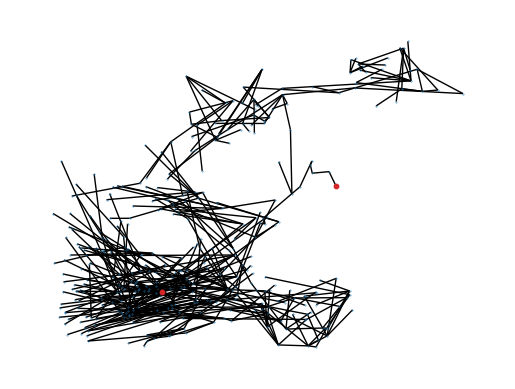

In [18]:
from matplotlib import pyplot
pyplot.gca().invert_yaxis()

nx.draw(G, nx.get_node_attributes(G, 'pos'), node_size=0.1)
print(G.has_node(node_start))
print(G.has_node(node_goal))
nx.draw_networkx_nodes(G, nx.get_node_attributes(G, 'pos'), nodelist=[node_start, node_goal], node_color="tab:red", node_size=10)

In [19]:
optim_path = nx.shortest_path(G, source=node_start, target=node_goal, weight="weight")
print(optim_path)

[(-4.9057903, 5.2627664, 0.30645654, -2.3005927, 0.49882576, -2.0617695, 0.24601075), (-6.436537, 6.3556757, 0.36343938, -1.0102547, -0.50801504, -2.0718021, -1.2830466), (-3.6535602, 5.6568923, -0.34076732, -0.6419125, 0.950271, -0.3434389, -0.30104214), (-6.046723, 6.473228, 2.233777, -1.8980747, 0.60339534, 0.28030437, -2.1178222), (-2.0873005, 5.4313984, 0.62708163, -1.427088, 1.1007079, -0.9329868, -2.930589), (-0.56070703, 8.194486, -0.8822241, 0.37588406, 2.3129377, -1.1483221, 0.45497093), (0.55368125, 8.244331, 1.9254647, -0.43609318, -0.56174904, -2.177796, -1.7728692), (1.2667106, 7.693485, 1.1089092, -1.135429, -0.12261233, 2.2730687, -1.9903178), (-0.9207842, 6.0804877, 0.80575943, -1.0804362, 0.38167787, -0.7272177, -3.1318638), (-4.694018, 6.1317043, 1.7079763, -1.6994083, -0.24892087, -1.6432602, -2.0929427), (-2.982193, 6.9411845, -0.6846256, -0.9130195, 1.1396078, -1.0231174, -0.8905673), (-4.0253415, 7.5358706, -1.7879896, 1.170313, 2.3984432, -2.3815768, 3.1116798),

In [20]:
env.plot_v2(optim_path)

In [21]:
from copy import deepcopy
graph = deepcopy(G)

number_nodes = len(graph.nodes)
nodes = list(graph.nodes)
count = 0
for i in range(number_nodes):
    collision = 0
    for j in range(i+1, number_nodes):
        node_x, node_y = nodes[i], nodes[j]
        if not graph.has_edge(node_x, node_y):
            if env._edge_fp(np.array(node_x), np.array(node_y)):
                # change distance method
                # graph.add_edge(node_x, node_y, weight=np.linalg.norm(np.array(node_x) - np.array(node_y)))
                
                graph.add_edge(node_x, node_y, weight=env.distance(np.array(node_x), np.array(node_y)))
                count = count + 1
            else:
                collision = collision + 1

        # if collision > 100:
        #     break
print("add {} edges".format(count))

add 655 edges


In [22]:
print(len(graph.nodes))
print(len(G.nodes))

358
358


In [23]:
optim_path = nx.shortest_path(graph, source=node_start, target=node_goal, weight="weight")
print(optim_path)

[(-4.9057903, 5.2627664, 0.30645654, -2.3005927, 0.49882576, -2.0617695, 0.24601075), (-6.337875, 5.0923886, 1.3770256, -1.7797815, 0.7216832, -2.248977, -0.4357981), (-7.3845835, 2.8315582, -0.36180604, 0.4896516, -0.17210086, -1.4943643, 1.0150708), (-7.25056, 1.9490638, -1.9870106, 1.3981205, -2.3766978, 2.1165273, -0.98910624), (-4.517704, 0.38501993, -1.3629397, 0.66405493, -1.8625947, 2.4062734, -2.5251865), (-1.4147502, 2.2279572, -1.5321577, 0.11239636, -1.5314875, 1.9699705, -3.1152227), (-3.7145016, 5.830997, -0.9627218, -1.158986, -1.7724689, 1.5141777, -2.0168397), (-5.2163043, 7.8163743, -1.7065418, -0.10723638, 2.1648986, 1.027195, -1.9595437), (-4.660277, 7.7164645, -2.079353, 0.3552712, 1.4061031, -1.6464618, 2.6107845), (-2.982193, 6.9411845, -0.6846256, -0.9130195, 1.1396078, -1.0231174, -0.8905673), (-4.0253415, 7.5358706, -1.7879896, 1.170313, 2.3984432, -2.3815768, 3.1116798), (-7.685914, 7.9785175, -2.1077719, -0.15755813, 2.1476986, 2.1195593, 2.9775627), (-2.904

In [24]:
env.plot_v2(optim_path)


In [25]:
print(len(optim_path))

23
